In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier

### LOAD DATA

In [2]:
bank = pd.read_csv(
    'https://raw.githubusercontent.com/tianqi72/BankChurners/main/BankChurners.csv')

# Remove two columns that leaks information
bank = bank.drop(columns=bank.columns[-2:], axis=1)
# Remove id column
bank = bank.drop(columns='CLIENTNUM', axis=1)

y = bank['Attrition_Flag']
X = bank.drop('Attrition_Flag', axis=1)
y = y.values.ravel()

bank.tail()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
10126,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189


### Encode the targets

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

### Split dataset into training and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Preoprocessing

In [5]:
# Impute missing values
# Standardize numerical variables
con_pipe = Pipeline([('scaler', StandardScaler()),
                     ('imputer', SimpleImputer(strategy='median',
                                               add_indicator=True))])
# Encode categorical variables
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('imputer', SimpleImputer(strategy='most_frequent',
                                               add_indicator=True))])

categorical_columns = (X.dtypes == object)
preprocessing = ColumnTransformer([('categorical', cat_pipe,
                                    categorical_columns),
                                   ('continuous',  con_pipe,
                                    ~categorical_columns)])

# Resampling
smote = SMOTE()

### Hyperparameter tuning

In [6]:
rf_pipe = make_pipeline(preprocessing,
                        smote,
                        RandomForestClassifier(n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         smote,
                         KNeighborsClassifier(n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         smote,
                         KNeighborsClassifier(n_jobs=-1))

svc_pipe = make_pipeline(preprocessing,
                         smote,
                         SVC())

xgb_pipe = make_pipeline(preprocessing,
                         smote,
                         XGBClassifier())

rf_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                smote__k_neighbors=range(2, 20),
                randomforestclassifier__n_estimators=[
                    *range(5, 100, 5), *range(100, 500, 100)],
                randomforestclassifier__max_depth=[*range(2, 30), None],
                randomforestclassifier__min_samples_split=range(1, 10),
                randomforestclassifier__min_samples_leaf=range(1, 10),
                randomforestclassifier__max_features=['auto', 'sqrt', 'log2'],
                randomforestclassifier__class_weight=[None, 'balanced'])

knn_hyper = dict(smote__sampling_strategy=[0.1, 0.2, 0.3, 0.4, 0.5, 'auto'],
                 smote__k_neighbors=range(2, 20),
                 kneighborsclassifier__n_neighbors=range(2, 20),
                 kneighborsclassifier__leaf_size=range(5, 51, 5),
                 kneighborsclassifier__weights=['uniform', 'distance'])

svc_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                 smote__k_neighbors=range(2, 20),
                 svc__C=[0.1, 0.3, 0.5, 1, 10, 50, 100],
                 svc__kernel=['linear', 'poly',
                              'rbf', 'sigmoid', 'precomputed'],
                 svc__gamma=['scale', 'auto'],
                 svc__degree=range(2, 5),
                 svc__class_weight=[None, 'balanced'])

xgb_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                 smote__k_neighbors=range(2, 20),
                 xgbclassifier__booster=['gbtree', 'gblinear', 'dart'],
                 xgbclassifier__eta=np.arange(0, 1, 0.1),
                 xgbclassifier__gamma=range(0, 10),
                 xgbclassifier__max_depth=range(2, 30),
                 xgbclassifier__subsample=np.arange(0.2, 1, 0.1),
                 xgbclassifier__sampling_method=['uniform', 'gradient_based'])

algorithms = [rf_pipe, knn_pipe, svc_pipe, xgb_pipe]
hypers = [rf_hyper, knn_hyper, svc_hyper, xgb_hyper]

for algorithm, hyper in zip(algorithms, hypers):
    clf_rand_cv = RandomizedSearchCV(estimator=algorithm,
                                     param_distributions=hyper,
                                     n_iter=50,
                                     cv=10,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=False)
    clf_rand_cv.fit(X_train, y_train)
    print(clf_rand_cv.best_params_)

{'smote__sampling_strategy': 0.4, 'smote__k_neighbors': 17, 'randomforestclassifier__n_estimators': 55, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__class_weight': 'balanced'}
{'smote__sampling_strategy': 0.30000000000000004, 'smote__k_neighbors': 18, 'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 16, 'kneighborsclassifier__leaf_size': 5}
{'svc__kernel': 'poly', 'svc__gamma': 'auto', 'svc__degree': 2, 'svc__class_weight': None, 'svc__C': 50, 'smote__sampling_strategy': 0.2, 'smote__k_neighbors': 16}
[08:42:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'xgbclassifie

### Model selection

In [9]:
rf_pipe = make_pipeline(preprocessing,
                        SMOTE(sampling_strategy=0.3, k_neighbors=19),
                        RandomForestClassifier(n_estimators=55,
                                               min_samples_split=3,
                                               min_samples_leaf=1,
                                               max_features='sqrt',
                                               max_depth=26,
                                               class_weight=None,
                                               n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.3,
                               k_neighbors=10),
                         KNeighborsClassifier(weights='distance',
                                              n_neighbors=15,
                                              leaf_size=25,
                                              n_jobs=-1))

svc_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.3, k_neighbors=8),
                         SVC(kernel='poly',
                             gamma='scale',
                             degree=4,
                             C=0.3))

xgb_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.2, k_neighbors=3),
                         XGBClassifier(subsample=0.6,
                                       sampling_method='uniform',
                                       max_depth=10,
                                       gamma=3,
                                       eta=0.2,
                                       booster='gbtree'))

algorithms = [rf_pipe, knn_pipe, svc_pipe, xgb_pipe]
name = ['RF', 'KNN', 'SVC', 'XG']
results = []
for pipe, name in zip(algorithms, name):
    score = cross_val_score(pipe, X_train, y_train, cv=5,
                            scoring='f1_weighted', n_jobs=-1)
    results.append(score)
    print(name, round(np.mean(score), 4))

RF 0.9495
KNN 0.9115
SVC 0.9128
XG 0.9701


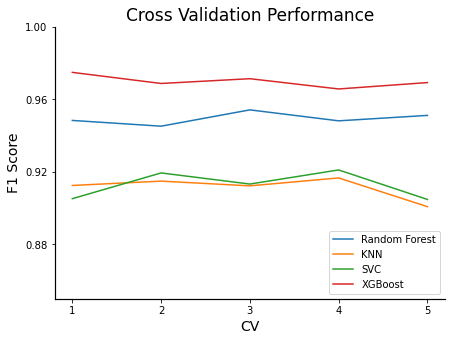

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
x = [1, 2, 3, 4, 5]
ax.plot(x, results[0], label="Random Forest")
ax.plot(x, results[1], label="KNN")
ax.plot(x, results[2], label="SVC")
ax.plot(x, results[3], label="XGBoost")
plt.ylim(0.85, 1)
ax.set_yticks([0.88, 0.92, 0.96, 1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title("Cross Validation Performance", size=17)
ax.set_xlabel("CV", size=14)
ax.set_ylabel("F1 Score", size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
plt.legend(loc='lower right')
plt.show()

### Final model evaluation

In [58]:
xgb_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.2,
                               k_neighbors=3),
                         XGBClassifier(subsample=0.6,
                                       sampling_method='uniform',
                                       max_depth=10,
                                       gamma=3,
                                       eta=0.2,
                                       booster='gbtree'))
xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[08:33:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 277   39]
 [  28 1682]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       316
           1       0.98      0.98      0.98      1710

    accuracy                           0.97      2026
   macro avg       0.94      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026

